# Lorenz Anchored Ensembling

Equations:

$$
\begin{cases}    
\dot{x}(t) = \sigma(y-x)\\
\dot{y}(t) = x(\rho-z)-y\\
\dot{z}(t) = xy-\beta z\\
\end{cases}
$$

so since $\mathbf{f}(u(t),t,\theta)$

We tackle the problem by training 10 Neural ODEs models with different initializations, to build an ensamble model, allowing us to retrieve uncertainty-related infos.

In [1]:
!pip install torchdiffeq

In [2]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
method = 'dopr15'
data_size = 1000
add_noise = True
data_noise = 0.001
batch_time = 200             # number of data points per batch
n_batches = 20              # number of batches
n_test_batches = 2
epochs = 2000
test_freq = 20
n_ensemble = 10
n_hidden = 50

anchored = True
n_data = batch_time
W1_var = 20. 
W_last_var = 1/n_hidden
W1_lambda = data_noise/W1_var
b1_var = W1_var
b1_lambda =  data_noise/b1_var
W_last_lambda = data_noise/W_last_var

gpu = 0
viz = False
adjoint = False
scale = True
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [4]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [5]:
true_u0 = torch.tensor([[.5, .5, .5]]).to(device)
t = torch.linspace(0., 5., data_size).to(device)

In [6]:
class true_vector_field(nn.Module):

    def forward(self, t, u):
        x = u[0][0]
        y = u[0][1]
        z = u[0][2]
        
        sigma = 14.
        rho = 10.
        beta = 8/3

        dxdt = sigma*(y-x)
        dydt = x*(rho-z)-y
        dzdt = x*y-beta*z
        return torch.tensor([ 
                            [ dxdt ],
                            [ dydt ],
                            [ dzdt ]
                             ]).reshape([1,3]).to(device)


In [7]:
with torch.no_grad():
    true_u = odeint(true_vector_field(), true_u0, t, method='dopri5') # [time,state] = [t,u(t)]
    non_scaled_true_u = true_u
    non_scaled_true_u0 = true_u0
    if scale:
        scaling = torch.max(true_u)
        true_u = true_u/scaling
        true_u0 = true_u0/scaling

In [8]:
def get_batch():
    # randomly select initial time t0 for the batches
    # get randomly n_batches starting point by leaving the last n_test_batches batch for testing
    s = torch.from_numpy(np.random.choice(np.arange(data_size - (n_test_batches+1)*batch_time, dtype=np.int64), n_batches, replace=False))
    # select the initial value for each batch
    batch_y0 = true_u[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_u[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    batch_y = batch_y + int(add_noise)*torch.randn_like(batch_y)*data_noise
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device), t[s]

In [9]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [10]:
if viz:
    makedirs('png')
    fig = plt.figure(figsize=(20, 6), facecolor='white')
#   ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase_1 = fig.add_subplot(131, frameon=False)
    ax_phase_2 = fig.add_subplot(132, frameon=False)
    ax_phase_3 = fig.add_subplot(133, frameon=False)
#   ax_vecfield = fig.add_subplot(133, frameon=False)
    plt.show(block=False)

In [11]:
plot_x_lim = 3
plot_y_lim = 3

def visualize(true_u, pred_u, odefunc, itr, batch_y, batch_t):

    if viz:

        ax_phase_1.cla()
        ax_phase_1.set_title('Phase Portrait, Species 1-2')
        ax_phase_1.set_xlabel('x1')
        ax_phase_1.set_ylabel('x2')
        ax_phase_1.plot(true_u.cpu().numpy()[:, 0, 0], true_u.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase_1.plot(pred_u.cpu().numpy()[:, 0, 0], pred_u.cpu().numpy()[:, 0, 1], 'b--')
        ax_phase_1.plot(batch_u0.cpu().numpy()[:, 0, 0], batch_u0.cpu().numpy()[:, 0, 1], 'r*')
        #ax_phase_1.set_xlim(0, plot_x_lim)
        #ax_phase_1.set_ylim(0, plot_y_lim)
        
        ax_phase_2.cla()
        ax_phase_2.set_title('Phase Portrait, Species 1-3')
        ax_phase_2.set_xlabel('x1')
        ax_phase_2.set_ylabel('x3')
        ax_phase_2.plot(true_u.cpu().numpy()[:, 0, 0], true_u.cpu().numpy()[:, 0, 2], 'g-')
        ax_phase_2.plot(pred_u.cpu().numpy()[:, 0, 0], pred_u.cpu().numpy()[:, 0, 2], 'b--')
        ax_phase_2.plot(batch_u0.cpu().numpy()[:, 0, 0], batch_u0.cpu().numpy()[:, 0, 2], 'r*')
        #ax_phase_2.set_xlim(0, plot_x_lim)
        #ax_phase_2.set_ylim(0, plot_y_lim)

        ax_phase_3.cla()
        ax_phase_3.set_title('Phase Portrait, Species 2-3')
        ax_phase_3.set_xlabel('x2')
        ax_phase_3.set_ylabel('x3')
        ax_phase_3.plot(true_u.cpu().numpy()[:, 0, 1], true_u.cpu().numpy()[:, 0, 2], 'g-')
        ax_phase_3.plot(pred_u.cpu().numpy()[:, 0, 1], pred_u.cpu().numpy()[:, 0, 2], 'b--')
        ax_phase_3.plot(batch_u0.cpu().numpy()[:, 0, 1], batch_u0.cpu().numpy()[:, 0, 2], 'r*')
        #ax_phase_3.set_xlim(0, plot_x_lim)
        #ax_phase_3.set_ylim(0, plot_y_lim)

        
        fig.tight_layout()
        fig.savefig('png/{:03d}'.format(itr))
        fig.show()
        #plt.draw()
        #plt.pause(0.001)

In [12]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 3)
        )
        
        self.net[0].weight.data.normal_(0.0, np.sqrt(W1_var))
        self.net[0].bias.data.normal_(0.0, np.sqrt(b1_var))
        self.net[2].weight.data.normal_(0.0, np.sqrt(W_last_var))
        self.net[2].bias.data.fill_(0.)

    def forward(self, t, y):
        return self.net(y)

In [13]:
def ensemble_pred(ensemble, u0, t):
  pred = torch.stack([odeint(func, true_u0, t).to(device) for func in ensemble])
  mean_pred = torch.mean(pred,0)
  std_pred = torch.std(pred,0)
  return pred,mean_pred,std_pred

# Extracted Data Visualization

In [14]:
batch_u0, batch_t, batch_u, ts = get_batch()
batch_u0.shape

torch.Size([20, 1, 3])

Text(0, 0.5, 'z')

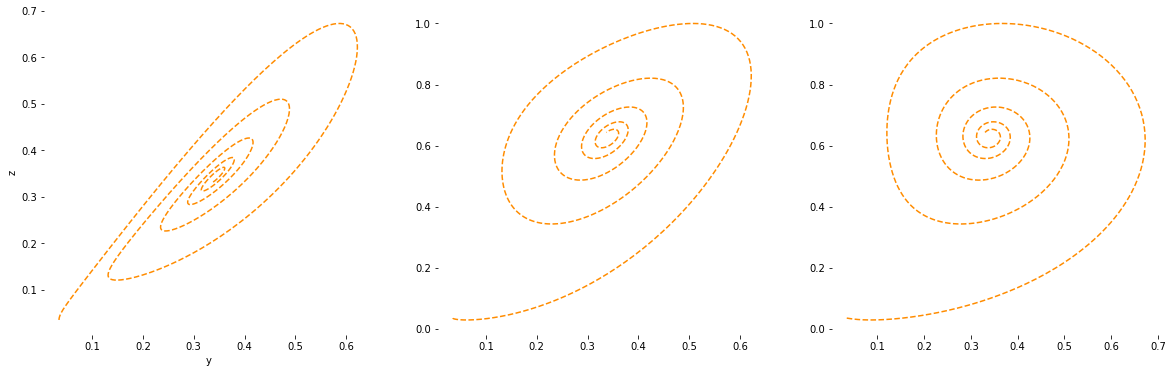

In [15]:
fig = plt.figure(figsize=(20, 6), facecolor='white')
ax_phase_1_true = fig.add_subplot(131, frameon=False)
ax_phase_1_true.plot(true_u[:, :, 0].cpu(), true_u[:, :, 1].cpu(), '--',color='darkorange')
ax_phase_1_true.set_xlabel('x')
ax_phase_1_true.set_ylabel('y')
ax_phase_2_true = fig.add_subplot(132, frameon=False)
ax_phase_2_true.plot(true_u[:, :, 0].cpu(), true_u[:, :, 2].cpu(), '--',color='darkorange')
ax_phase_1_true.set_xlabel('x')
ax_phase_1_true.set_ylabel('z')
ax_phase_3_true = fig.add_subplot(133, frameon=False)
ax_phase_3_true.plot(true_u[:, :, 1].cpu(), true_u[:, :, 2].cpu(), '--',color='darkorange')
ax_phase_1_true.set_xlabel('y')
ax_phase_1_true.set_ylabel('z')

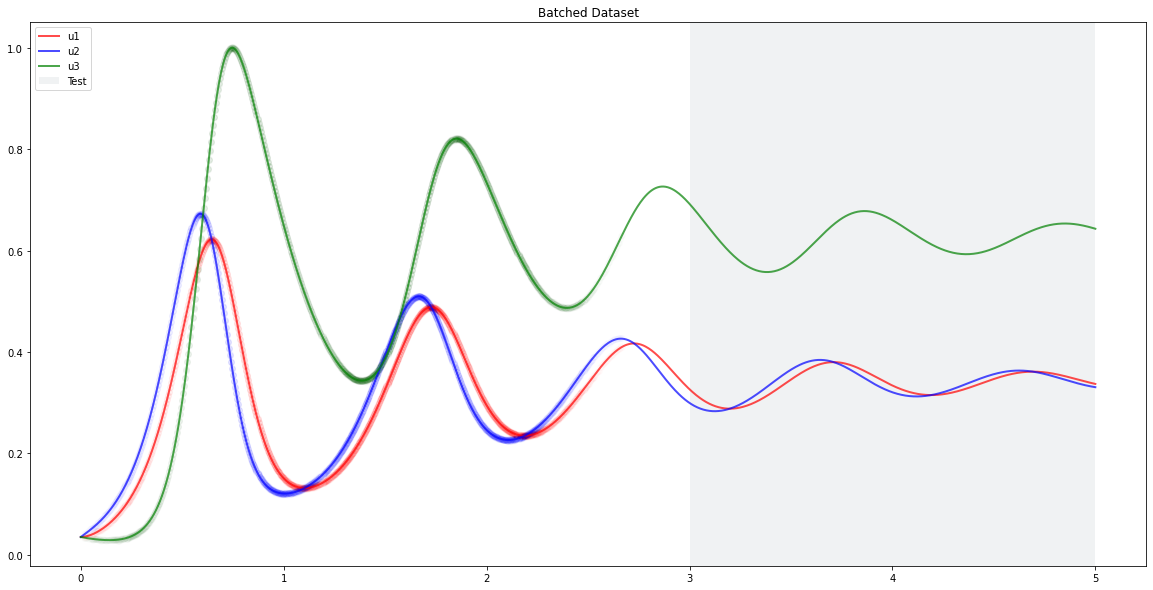

In [16]:
fig = plt.figure(figsize=(20, 10), facecolor='white',frameon=False)
show_1_batch = False
batch_i=np.random.choice(range(n_batches))
batched_time = batch_t + ts[batch_i]*torch.ones_like(batch_t)

colors = ['r','b','g']

for j in range(3):
    lab = 'u'+str(j+1)
    #plt.scatter(ts.cpu().numpy(),batch_u0.cpu().numpy()[:,:,j],marker='o',color='silver')
    plt.plot(t.cpu().numpy(),true_u.cpu().numpy()[:, :, j],label=lab,color=colors[j],alpha=0.7,linewidth=2)
    if show_1_batch:
            plt.scatter(batched_time.cpu().numpy(),batch_u.cpu().numpy()[:,batch_i,:,j],color=colors[j],marker='.',alpha=.1)
    else:
        for batch_i in range(n_batches):
            batched_time = batch_t + ts[batch_i]*torch.ones_like(batch_t)
            plt.scatter(batched_time.cpu().numpy(),batch_u.cpu().numpy()[:,batch_i,:,j],color=colors[j],marker='o',alpha=.01)


#plt.plot(t,true_u[:, :, j],'--r',label='Ground truth')
plt.axvspan(t[data_size-n_test_batches*batch_time].cpu().numpy(), t[-1].cpu().numpy(), facecolor='slategrey', alpha=0.1,label='Test')

plt.title('Batched Dataset')
plt.legend()

## Training

In [17]:
ensemble = [ODEFunc().to(device) for j in range(n_ensemble)]

In [18]:
pred,mean_pred,std_pred = ensemble_pred(ensemble, true_u0, t)

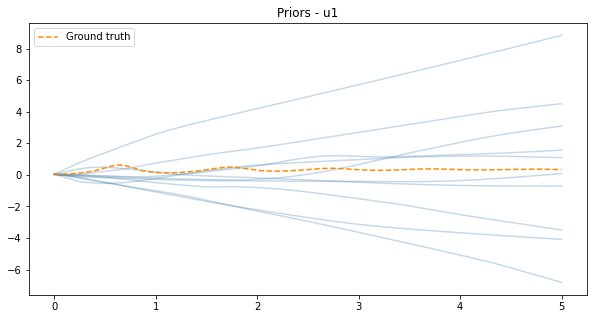

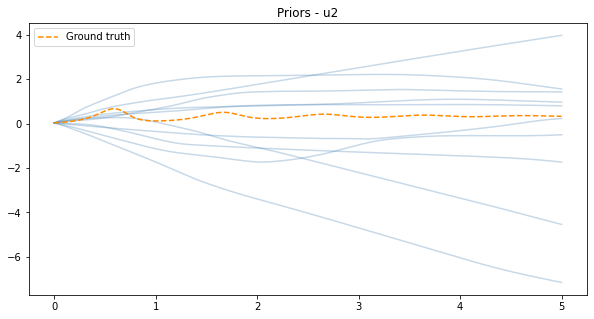

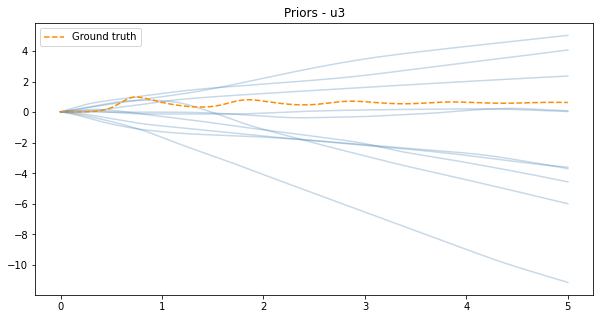

In [19]:
with torch.no_grad():
  a = .3
  for j in range(3):
    fig = plt.figure(figsize=(10, 5), facecolor='white',frameon=False)

    for pred_u in pred:
      plt.plot(t.cpu().numpy(),pred_u[:, :, j].cpu().numpy(),color='steelblue',alpha=a)

   # plt.plot(t.cpu().numpy(),mean_pred[:, :, j].cpu().numpy(),color=colors[j],linewidth=2,label='Mean')
   # plt.plot(t.cpu().numpy(),mean_pred[:, :, j].cpu().numpy()+2*std_pred[:, :, j].cpu().numpy(),color='limegreen',label='2σ',linewidth=1)
   # plt.plot(t.cpu().numpy(),mean_pred[:, :, j].cpu().numpy()-2*std_pred[:, :, j].cpu().numpy(),color='limegreen',linewidth=1)
   # plt.scatter(batch_t,batch_u[:,0,:,j])
    plt.plot(t.cpu().numpy(),true_u[:, :, j].cpu().numpy(),'--',color='darkorange',label='Ground truth')
   # plt.axvspan(t[data_size-batch_time].cpu().numpy(), t[-1], facecolor='steelblue', alpha=0.2,label='Extrapolation')
    plt.title('Priors - u'+str(j+1))
    plt.legend()

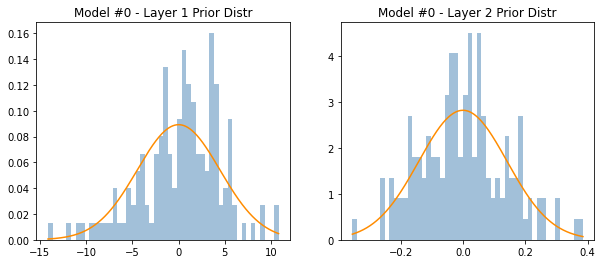

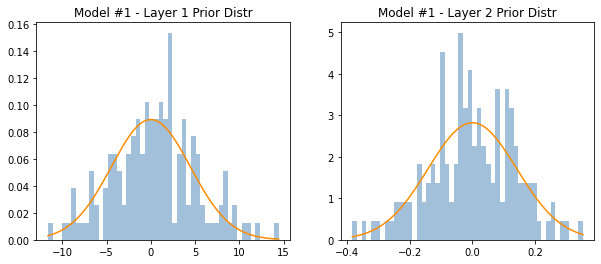

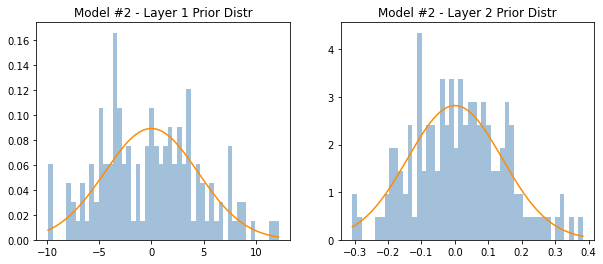

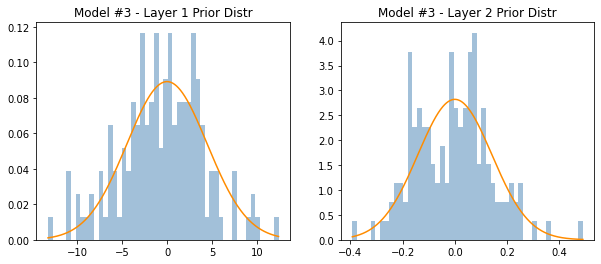

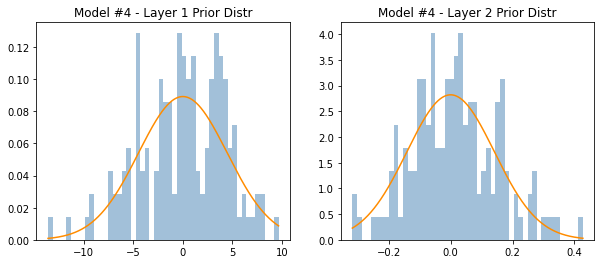

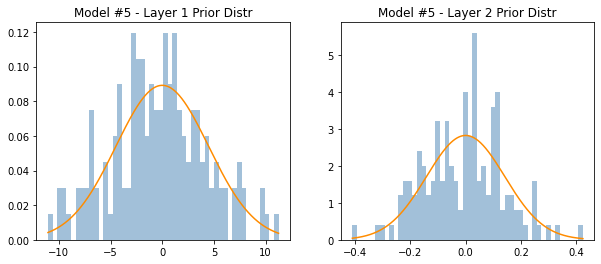

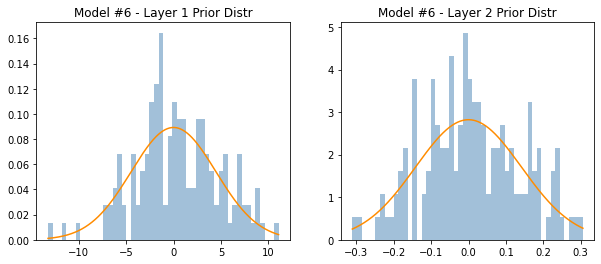

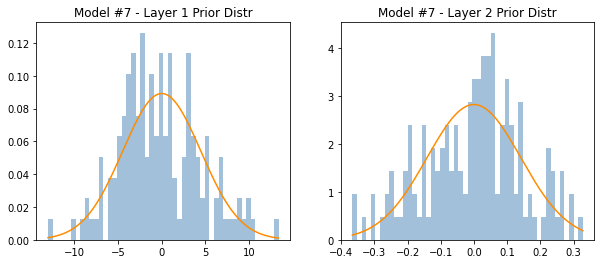

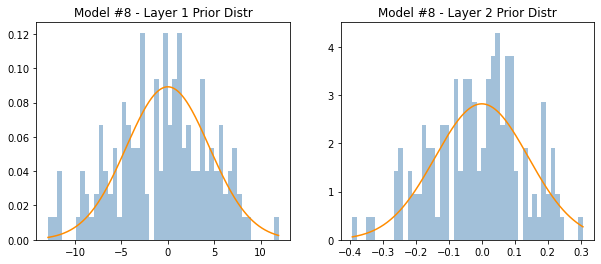

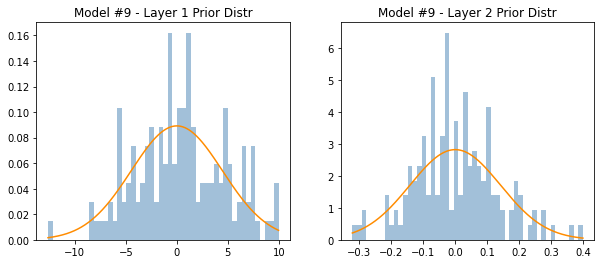

In [20]:
for i,func in enumerate(ensemble):
    weights1 = func.net[0].weight.reshape(n_hidden*3).detach().cpu().numpy()
    weights2 = func.net[2].weight.reshape(n_hidden*3).detach().cpu().numpy()
    
    fig = plt.figure(figsize=(10,4))
    p1 = fig.add_subplot(121)
    x = np.linspace(weights1.min(),weights1.max(),1000)
    true_density = 1/np.sqrt(2*np.pi*W1_var)*np.exp(-(x*x)/(2*W1_var))
    p1.hist(weights1, 50, density=True, facecolor='steelblue', alpha=0.50)
    p1.plot(x,true_density,color='darkorange')
    p1.set_title('Model #'+ str(i) +' - Layer 1 Prior Distr')
    p2 = fig.add_subplot(122)
    x = np.linspace(weights2.min(),weights2.max(),1000)
    true_density = 1/np.sqrt(2*np.pi*W_last_var)*np.exp(-(x*x)/(2*W_last_var))
    p2.hist(weights2, 50, density=True, facecolor='steelblue', alpha=0.50)
    p2.set_title('Model #'+ str(i) +' - Layer 2 Prior Distr')
    p2.plot(x,true_density,color='darkorange')


In [21]:
ii = 0
lrate = 1e-3
training_data = []

for i,func in enumerate(ensemble):

    print("Model #"+str(i))
    
    optimizer = optim.RMSprop(func.parameters(), lr=lrate)

    W1_anc = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_hidden,1])
    b1_anc = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])
    W_last_anc = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[1,n_hidden])
    W1_anc = torch.tensor(W1_anc).float().to(device)
    b1_anc = torch.tensor(b1_anc).float().to(device)
    W_last_anc = torch.tensor(W_last_anc).float().to(device)

    loss_array = []
    itr_time = []

    start = time.time()
    for itr in range(1, epochs + 1):

        start_itr = time.time()
        

        batch_u0, batch_t, batch_u, ts = get_batch()
        training_data.append([batch_u,batch_t,ts])
        pred_u = odeint(func, batch_u0, batch_t).to(device)
        
        l2 = 0
        if anchored:
        #   l2 += W1_lambda/n_data * torch.mean(torch.pow(func.net[0].weight - W1_anc, 2))
        #   l2 += b1_lambda/n_data * torch.mean(torch.pow(func.net[0].bias - b1_anc, 2))
        #   l2 += W_last_lambda/n_data * torch.mean(torch.pow(func.net[2].weight - W_last_anc, 2))
            l2 += W1_lambda/n_data * (torch.pow(func.net[0].weight - W1_anc, 2)).sum()
            l2 += b1_lambda/n_data * (torch.pow(func.net[0].bias - b1_anc, 2)).sum()
            l2 += W_last_lambda/n_data * (torch.pow(func.net[2].weight - W_last_anc, 2)).sum()
        
        loss = torch.mean(torch.pow(pred_u - batch_u,2)) + l2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        itr_time.append(time.time()-start_itr)
        
        if itr % test_freq == 0:
            with torch.no_grad():
                loss_array.append(loss.item())
                print('Iter ' + str(itr)+'/'+str(epochs) + '\t|  Loss: ' + str(round(loss.item(),6)) + '\t|  lr: ' + str(optimizer.param_groups[0]['lr']) + '\t|  itr time: ' +str(round(itr_time[-1],5))+' s')
                #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
                #       ii += 1

    total_elapsed_time = time.time()-start

Model #0
Iter 20/2000	|  Loss: 0.048198	|  lr: 0.001	|  itr time: 0.23971 s
Iter 40/2000	|  Loss: 0.042174	|  lr: 0.001	|  itr time: 0.23511 s
Iter 60/2000	|  Loss: 0.03617	|  lr: 0.001	|  itr time: 0.24858 s
Iter 80/2000	|  Loss: 0.037471	|  lr: 0.001	|  itr time: 0.23197 s
Iter 100/2000	|  Loss: 0.030304	|  lr: 0.001	|  itr time: 0.2585 s
Iter 120/2000	|  Loss: 0.032318	|  lr: 0.001	|  itr time: 0.23626 s
Iter 140/2000	|  Loss: 0.029897	|  lr: 0.001	|  itr time: 0.25372 s
Iter 160/2000	|  Loss: 0.021878	|  lr: 0.001	|  itr time: 0.24031 s
Iter 180/2000	|  Loss: 0.029588	|  lr: 0.001	|  itr time: 0.25101 s
Iter 200/2000	|  Loss: 0.02854	|  lr: 0.001	|  itr time: 0.25953 s
Iter 220/2000	|  Loss: 0.02408	|  lr: 0.001	|  itr time: 0.24631 s
Iter 240/2000	|  Loss: 0.032847	|  lr: 0.001	|  itr time: 0.24864 s
Iter 260/2000	|  Loss: 0.024954	|  lr: 0.001	|  itr time: 0.24656 s
Iter 280/2000	|  Loss: 0.031522	|  lr: 0.001	|  itr time: 0.2845 s
Iter 300/2000	|  Loss: 0.031606	|  lr: 0.001	|  

In [22]:
print('Training time per model: {:f} min  |  avg time per epoch : {:f} s'.format(total_elapsed_time/60, np.mean(np.array(itr_time))))

Training time per model: 12.271627 min  |  avg time per epoch : 0.368125 s


## Test

In [23]:
pred,mean_pred,std_pred = ensemble_pred(ensemble, true_u0, t)

In [24]:
gtc = 'r'
c_pred = 'b'
a=.15

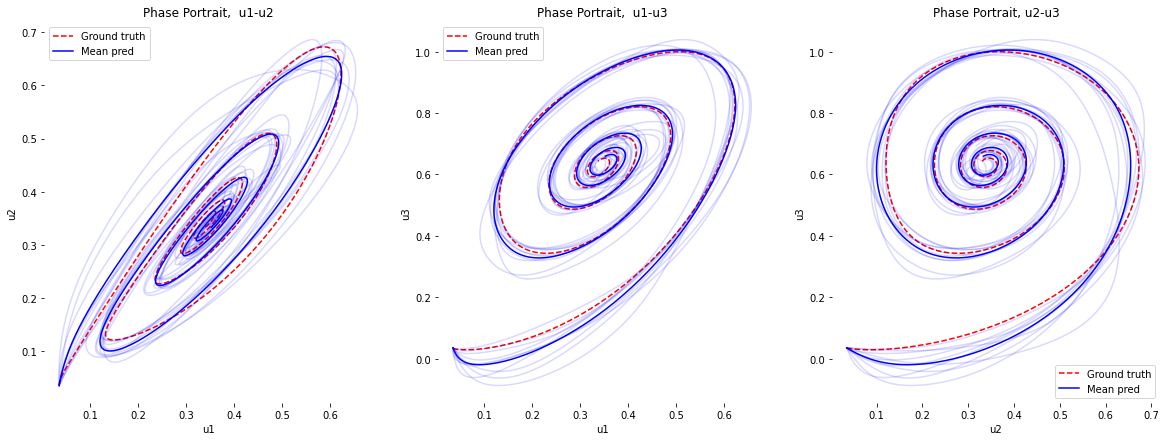

In [25]:
with torch.no_grad():

    fig = plt.figure(figsize=(20, 7), facecolor='white')

    ax_phase_1_test = fig.add_subplot(131, frameon=False)
    ax_phase_1_test.set_title('Phase Portrait,  u1-u2')
    ax_phase_1_test.set_xlabel('u1')
    ax_phase_1_test.set_ylabel('u2')
    ax_phase_1_test.plot(true_u[:, :, 0].cpu(), true_u[:, :, 1].cpu(), '--', color=gtc,label='Ground truth')
    ax_phase_1_test.plot(mean_pred[:, :, 0].cpu(), mean_pred[:, :, 1].cpu(), '-', color=c_pred,label='Mean pred')


    ax_phase_2_test = fig.add_subplot(132, frameon=False)
    ax_phase_2_test.set_title('Phase Portrait,  u1-u3')
    ax_phase_2_test.set_xlabel('u1')
    ax_phase_2_test.set_ylabel('u3')
    ax_phase_2_test.plot(true_u[:, :, 0].cpu(), true_u[:, :, 2].cpu(), '--', color=gtc,label='Ground truth')
    ax_phase_2_test.plot(mean_pred[:, :, 0].cpu(), mean_pred[:, :, 2].cpu(), '-', color=c_pred,label='Mean pred')


    ax_phase_3_test = fig.add_subplot(133, frameon=False)
    ax_phase_3_test.set_title('Phase Portrait, u2-u3')
    ax_phase_3_test.set_xlabel('u2')
    ax_phase_3_test.set_ylabel('u3')
    ax_phase_3_test.plot(true_u[:, :, 1].cpu(), true_u[:, :, 2].cpu(), '--', color=gtc,label='Ground truth')
    ax_phase_3_test.plot(mean_pred[:, :, 1].cpu(), mean_pred[:, :, 2].cpu(), '-', color=c_pred,label='Mean pred')

    for pred_u in pred:
        ax_phase_1_test.plot(pred_u[:, :, 0].cpu(), pred_u[:, :, 1].cpu(), '-', color=c_pred,alpha=a)
        ax_phase_2_test.plot(pred_u[:, :, 0].cpu(), pred_u[:, :, 2].cpu(), '-', color=c_pred,alpha=a)
        ax_phase_3_test.plot(pred_u[:, :, 1].cpu(), pred_u[:, :, 2].cpu(), '-',  color=c_pred,alpha=a)
    
    ax_phase_1_test.legend()
    ax_phase_2_test.legend()
    ax_phase_3_test.legend()

/opt/conda/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/opt/conda/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


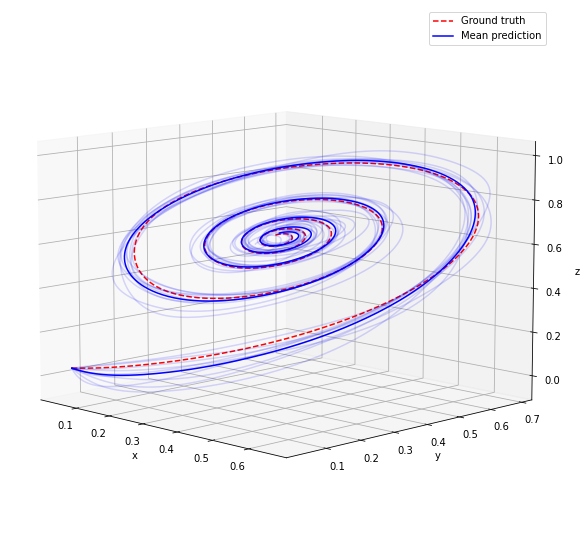

In [26]:
with torch.no_grad():
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')


    ax.plot3D(true_u[:, :, 0].cpu().flatten(), true_u[:, :, 1].cpu().flatten(), true_u[:, :, 2].cpu().flatten(),'--',color=gtc,label='Ground truth')
    ax.plot3D(mean_pred[:, :, 0].cpu().flatten(), mean_pred[:, :, 1].cpu().flatten(), mean_pred[:, :, 2].cpu().flatten(),color=c_pred,label='Mean prediction')
    for pred_u in pred:
            ax.plot3D(pred_u[:, :, 0].cpu().flatten(), pred_u[:, :, 1].cpu().flatten(), pred_u[:, :, 2].cpu().flatten(), '-', color=c_pred,alpha=a)

    ax.view_init(10, -45)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.legend() 
    plt.savefig('orbits3d.png',dpi=200)

/opt/conda/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/opt/conda/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


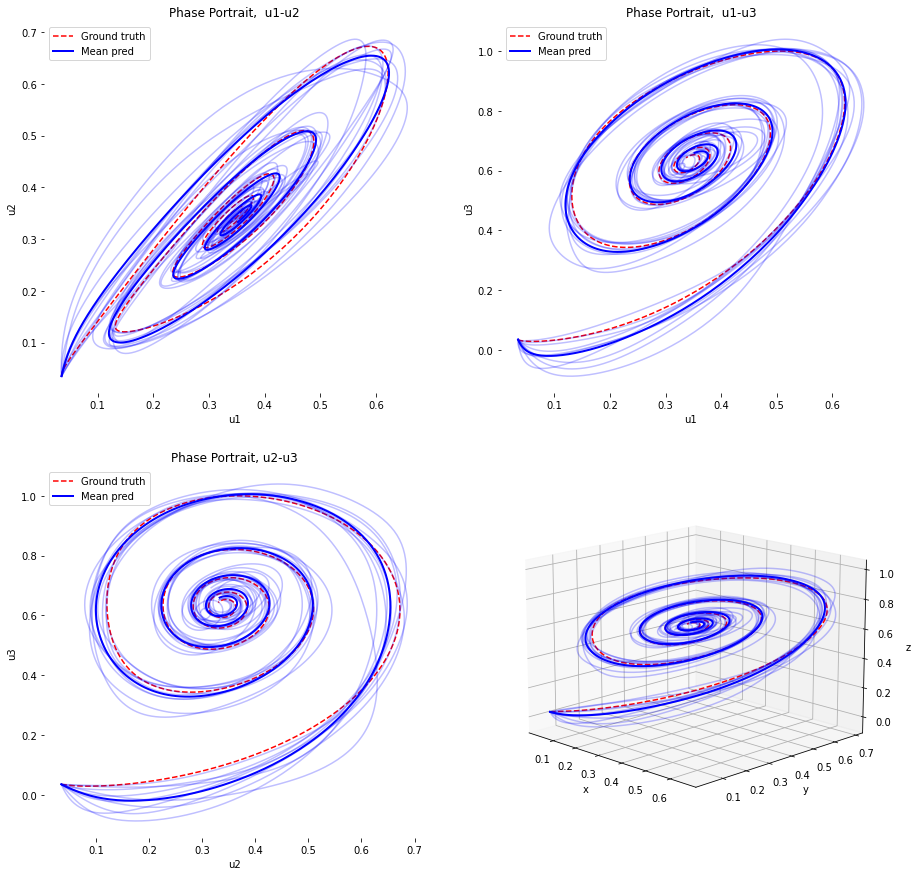

In [27]:
with torch.no_grad():

    fig = plt.figure(figsize=(15, 15), facecolor='white')

    ax_phase_1_test = fig.add_subplot(221, frameon=False)
    ax_phase_1_test.set_title('Phase Portrait,  u1-u2')
    ax_phase_1_test.set_xlabel('u1')
    ax_phase_1_test.set_ylabel('u2')
    ax_phase_1_test.plot(true_u[:, :, 0].cpu(), true_u[:, :, 1].cpu(), '--', color=gtc,label='Ground truth')
    ax_phase_1_test.plot(mean_pred[:, :, 0].cpu(), mean_pred[:, :, 1].cpu(), '-', color=c_pred,label='Mean pred',linewidth=2)


    ax_phase_2_test = fig.add_subplot(222, frameon=False)
    ax_phase_2_test.set_title('Phase Portrait,  u1-u3')
    ax_phase_2_test.set_xlabel('u1')
    ax_phase_2_test.set_ylabel('u3')
    ax_phase_2_test.plot(true_u[:, :, 0].cpu(), true_u[:, :, 2].cpu(), '--', color=gtc,label='Ground truth')
    ax_phase_2_test.plot(mean_pred[:, :, 0].cpu(), mean_pred[:, :, 2].cpu(), '-', color=c_pred,label='Mean pred',linewidth=2)


    ax_phase_3_test = fig.add_subplot(223, frameon=False)
    ax_phase_3_test.set_title('Phase Portrait, u2-u3')
    ax_phase_3_test.set_xlabel('u2')
    ax_phase_3_test.set_ylabel('u3')
    ax_phase_3_test.plot(true_u[:, :, 1].cpu(), true_u[:, :, 2].cpu(), '--', color=gtc,label='Ground truth')
    ax_phase_3_test.plot(mean_pred[:, :, 1].cpu(), mean_pred[:, :, 2].cpu(), '-', color=c_pred,label='Mean pred',linewidth=2)

    a=.25
    for pred_u in pred:
        ax_phase_1_test.plot(pred_u[:, :, 0].cpu(), pred_u[:, :, 1].cpu(), '-', color=c_pred,alpha=a)
        ax_phase_2_test.plot(pred_u[:, :, 0].cpu(), pred_u[:, :, 2].cpu(), '-', color=c_pred,alpha=a)
        ax_phase_3_test.plot(pred_u[:, :, 1].cpu(), pred_u[:, :, 2].cpu(), '-',  color=c_pred,alpha=a)
    
    
    ax_3dphase_test = fig.add_subplot(224, projection='3d')

    ax_3dphase_test.plot3D(true_u[:, :, 0].cpu().flatten(), true_u[:, :, 1].cpu().flatten(), true_u[:, :, 2].cpu().flatten(),'--',color=gtc,label='Ground truth')
    ax_3dphase_test.plot3D(mean_pred[:, :, 0].cpu().flatten(), mean_pred[:, :, 1].cpu().flatten(), mean_pred[:, :, 2].cpu().flatten(),color=c_pred,label='Mean prediction',linewidth=2)
    for pred_u in pred:
            ax_3dphase_test.plot3D(pred_u[:, :, 0].cpu().flatten(), pred_u[:, :, 1].cpu().flatten(), pred_u[:, :, 2].cpu().flatten(), '-', color=c_pred,alpha=a)

    ax_3dphase_test.view_init(15, -45)
    ax_3dphase_test.set_xlabel('x')
    ax_3dphase_test.set_ylabel('y')
    ax_3dphase_test.set_zlabel('z')
    
    ax_phase_1_test.legend()
    ax_phase_2_test.legend()
    ax_phase_3_test.legend()

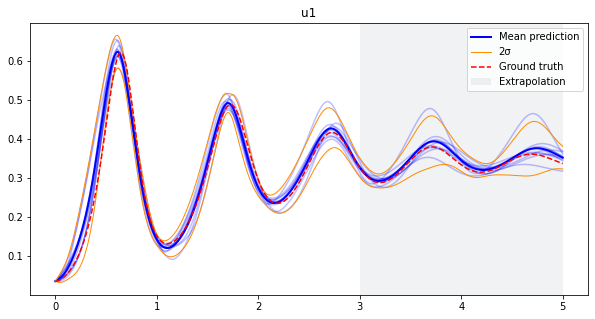

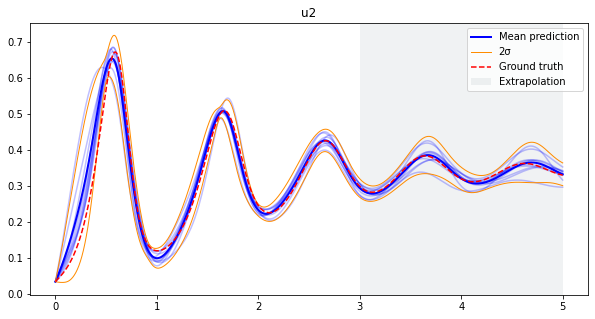

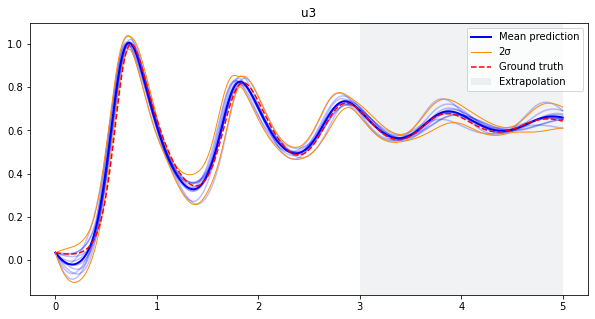

In [28]:
with torch.no_grad():

  for j in range(3):
    fig = plt.figure(figsize=(10, 5), facecolor='white',frameon=False)

    for pred_u in pred:
      plt.plot(t.cpu(),pred_u[:, :, j].cpu(),color=c_pred,alpha=a)
      #for batch_i in range(n_batches):
        #batched_time = batch_t + ts[batch_i]*torch.ones_like(batch_t)
        #plt.scatter(batched_time.cpu().numpy(),batch_u.cpu().numpy()[:,batch_i,:,j],color='r',marker='.',alpha=0.01)


    plt.plot(t.cpu(),mean_pred[:, :, j].cpu(),color=c_pred,linewidth=2,label='Mean prediction')
    plt.plot(t.cpu(),mean_pred[:, :, j].cpu()+2*std_pred[:, :, j].cpu(),color='darkorange',label='2σ',linewidth=1)
    plt.plot(t.cpu(),mean_pred[:, :, j].cpu()-2*std_pred[:, :, j].cpu(),color='darkorange',linewidth=1)
    #plt.scatter(batch_t,batch_u[:,0,:,j])
    plt.plot(t.cpu(),true_u[:, :, j].cpu(),'--',color=gtc,label='Ground truth')
    plt.axvspan(t[data_size-n_test_batches*batch_time].cpu(), t[-1].cpu(), facecolor='slategrey', alpha=0.1,label='Extrapolation')
    plt.title('u'+str(j+1))
    plt.legend()

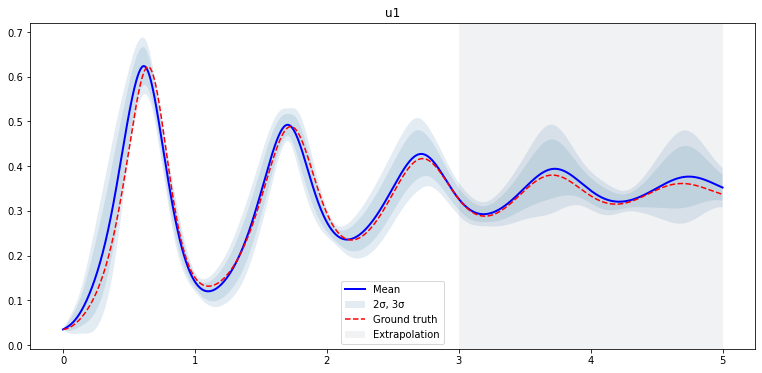

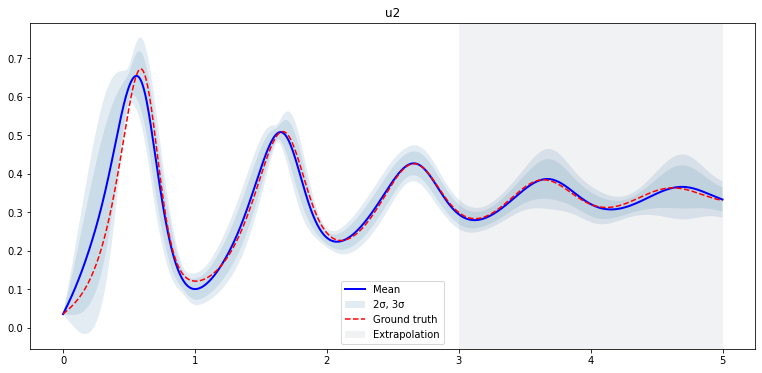

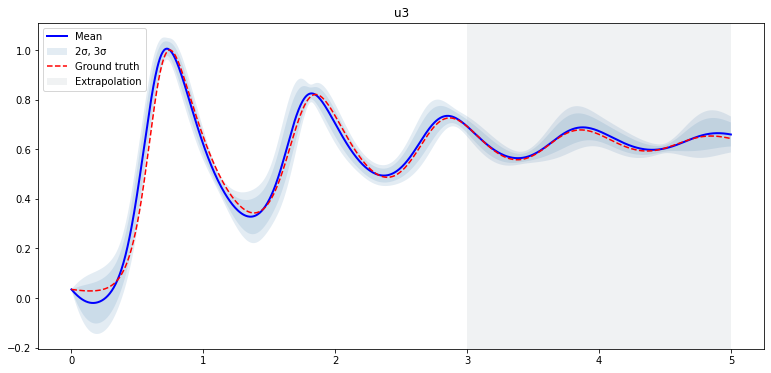

In [29]:
with torch.no_grad():
    for j in range(3):
        fig = plt.figure(figsize=(13, 6), facecolor='white',frameon=False)


        plt.plot(t.cpu(),mean_pred[:, :, j].cpu(),color=c_pred,linewidth=2,label='Mean')
        plt.fill_between(t.cpu(),torch.flatten(mean_pred[:, :, j]+2*std_pred[:, :, j]).cpu(),torch.flatten(mean_pred[:, :, j]-2*std_pred[:, :, j]).cpu(),facecolor='steelblue',alpha=.15,label='2σ, 3σ')
        plt.fill_between(t.cpu(),torch.flatten(mean_pred[:, :, j]+3*std_pred[:, :, j]).cpu(),torch.flatten(mean_pred[:, :, j]-3*std_pred[:, :, j]).cpu(),facecolor='steelblue',alpha=.15)

        #plt.scatter(batch_t,batch_u[:,0,:,j])
        plt.plot(t.cpu(),true_u[:, :, j].cpu(),'--r',label='Ground truth')
        plt.axvspan(t[data_size-n_test_batches*batch_time].cpu(), t[-1].cpu(), facecolor='slategrey', alpha=0.1,label='Extrapolation')
        plt.title('u'+str(j+1))
        plt.legend()

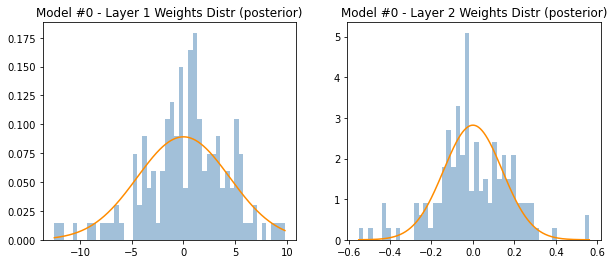

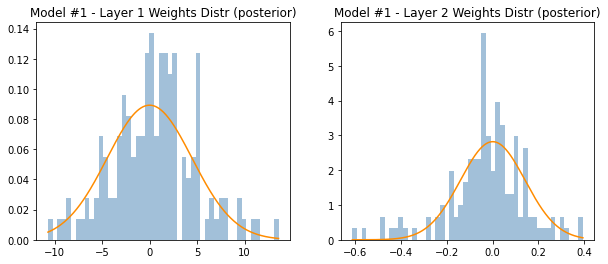

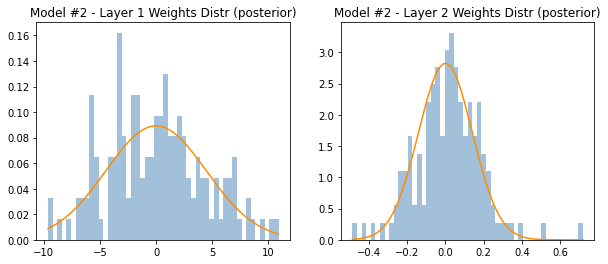

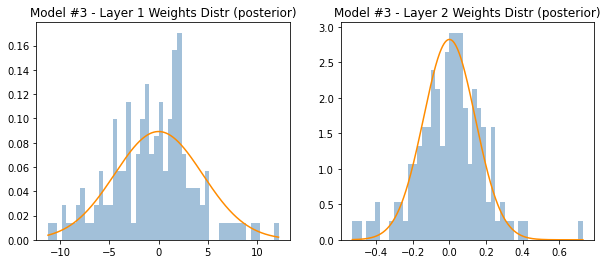

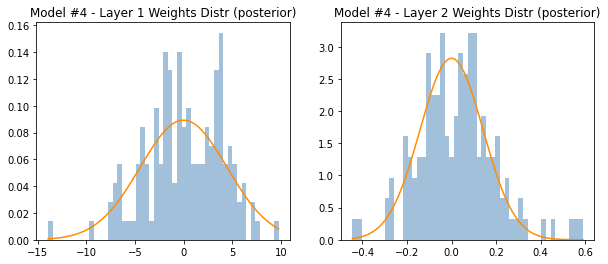

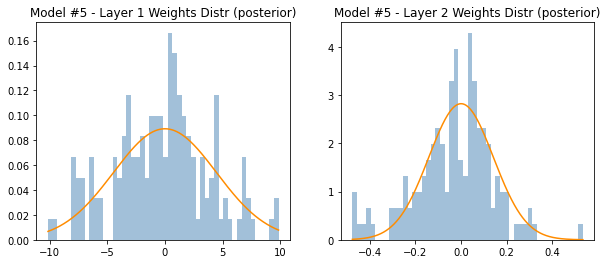

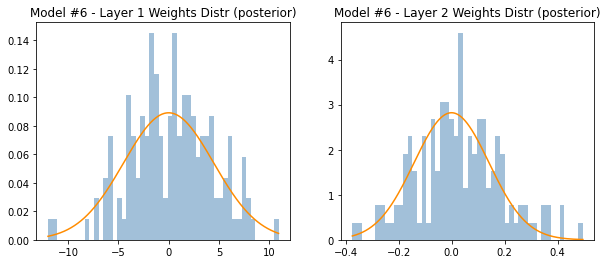

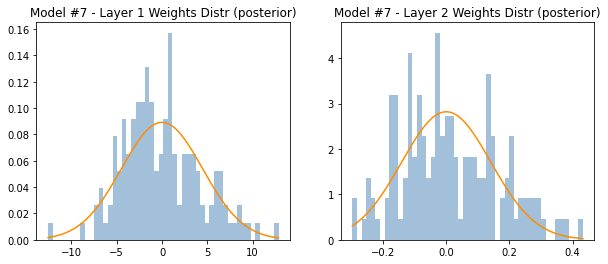

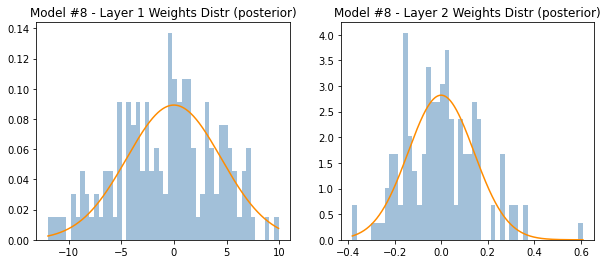

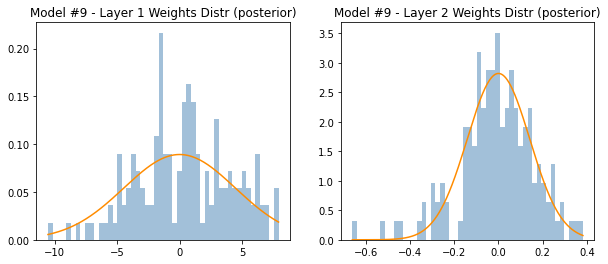

In [30]:
for i,func in enumerate(ensemble):
    weights1 = func.net[0].weight.reshape(n_hidden*3).detach().cpu().numpy()
    weights2 = func.net[2].weight.reshape(n_hidden*3).detach().cpu().numpy()
    
    fig = plt.figure(figsize=(10,4))
    p1 = fig.add_subplot(121)
    x = np.linspace(weights1.min(),weights1.max(),1000)
    true_density = 1/np.sqrt(2*np.pi*W1_var)*np.exp(-(x*x)/(2*W1_var))
    p1.hist(weights1, 50, density=True, facecolor='steelblue', alpha=0.50)
    p1.plot(x,true_density,color='darkorange')
    p1.set_title('Model #'+ str(i) +' - Layer 1 Weights Distr (posterior)')
    p2 = fig.add_subplot(122)
    x = np.linspace(weights2.min(),weights2.max(),1000)
    true_density = 1/np.sqrt(2*np.pi*W_last_var)*np.exp(-(x*x)/(2*W_last_var))
    p2.hist(weights2, 50, density=True, facecolor='steelblue', alpha=0.50)
    p2.set_title('Model #'+ str(i) +' - Layer 2 Weights Distr (posterior)')
    p2.plot(x,true_density,color='darkorange')


In [31]:
print('MSE: ',float(torch.mean(torch.pow(mean_pred-true_u,2))), '  |  MSE: ',float(torch.mean(torch.abs(mean_pred-true_u))))

MSE:  0.0007906605605967343   |  MSE:  0.017015181481838226


In [32]:
def save_ensemble(ensemble):
    for i,model in enumerate(ensemble):
        torch.save(model,'ef'+str(i)+'.pt')

In [33]:
save_ensemble(ensemble)